### The following packages were installed:

Other packages such as `spacy` had been installed before. This code was run in a venv in my MBP with Python 3.9 and Conda. 

Stopwords from English used.

For reproducibility: I can just reload pickles at the end of the code (lemmatizing takes a long time)

## st3f: removes drop_lowvalue_words_parallel

In [2]:
import csv, gensim, glob, importlib, json, mpfiles, os, pickle, pyLDAvis, re, spacy, string, sys, warnings
import numpy as np, pandas as pd, gensim.corpora as corpora, utilities as ut
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.test.utils import datapath
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
from gensim.corpora import MmCorpus
from gensim.models.coherencemodel import CoherenceModel

importlib.reload(mpfiles)

warnings.filterwarnings('ignore')

basedir = '../'
sys.path.append(basedir)

stopwords = stopwords.words("english")
min10kwords = 200
filename_list = []

def create_textsmp(yr):
    print(f"Creating texts")
    texts = []
    i = 0
    filename_list = []
    results = []
    for qtr in [1,2,3,4]:
        pool = mp.Pool(mp.cpu_count())
        print(f"Pool started with {mp.cpu_count()} cores. Qtr {qtr}")
        for filename in glob.glob(f'/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/1A files/{yr}/Q{qtr}/*.txt'):
            results.append(pool.apply_async(mpfiles.process_file, args=(filename,)))
            i += 1
            if i % 500 == 0:
                print(f"Created {i} texts so far")
        pool.close()
        pool.join()
    for r in results:
        result = r.get()
        filename, doc = result
        filename_list.append(filename)    
        texts.append(doc)                 
    return texts, filename_list

def lemmatization(old_texts, selection, yr, num_processes=mp.cpu_count()):
    idxs_to_keep = selection['order_in_cik']
    print(f"Starting lemmatization")
    pool = mp.Pool(num_processes)
    results = []
    texts = [old_texts[i] for i in idxs_to_keep]
    for i, text in enumerate(texts):
        results.append(pool.apply_async(mpfiles.lemmatize_text, args=(text,)))
        # Print progress: every 500 iterations print the iteration number
        if (i+1) % 500 == 0:
            print(f"Lemmatized {i+1} texts so far")
    pool.close()
    pool.join()
    texts_out = [r.get() for r in results]
    path = f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/lemmatized_texts/{yr}"
# Create the directory if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)
    # Save the vector as a pickle file
    with open(os.path.join(path, f"lemmatized_texts{yr}.pkl"), "wb") as f:
        pickle.dump(texts_out, f)
    
    with open(os.path.join(path, f"lem_filter{yr}.pkl"), "wb") as f:
        pickle.dump(selection, f)
    
    return texts_out

def drop_lowvalue_words_parallel(corpus, tfidf, low_value, words_missing_in_tfidf):
    
    print("Dropping low value words.")
    num_processes = mp.cpu_count() - 1
    pool = mp.Pool(processes=num_processes)

    chunk_size = int(len(corpus) / num_processes)
    chunks = [corpus[i:i+chunk_size] for i in range(0, len(corpus), chunk_size)]
    results = pool.map(partial(mpfiles.droplowvwords_chunk, tfidf=tfidf, low_value = low_value, words_missing_in_tfidf = [] ), chunks)
    pool.close()
    pool.join()

    # Concatenate the results
    new_corpus = [bow for chunk in results for bow in chunk]

    return new_corpus


In [3]:
cpsrc = 'full'
remake_id2word = False
remake_lemmatization = False
remake_ldamodel = False
remake_multiyear_topic_map = False
remake_corpus = False
show_model = False
no_below = 40 # Suppose 40256*0.001. Follows Bybee et al.
no_above = 1 
keep_n = None
yearlist = [year for year in range(2006, 2023, 1)]
min_count = 10 # For bigrams. Useless bigrams will be filtered out anyway
thr = 10 # For bigrams. Useless bigrams will be filtered out anyway
scorfun = "default" # For bigrams. Works best after trying the other type (npmi)
numtopiclist = [3,6,8] 
#numtopiclist = [4] # Choose as you like.
dicname = f"dic{cpsrc}mc{min_count}thr{str(thr).replace('.', '_')}{scorfun[:3]}nob{no_below}noa{str(no_above).replace('.', '_')}"
dicpath = f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/id2word/{dicname}.txt"
corpuspath = f'/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpora/{dicname}/corpus_full.mm' 
cequity_mapper = pd.read_csv("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/input/cequity_mapper.csv")
if remake_lemmatization:    
    for yr in yearlist:
        print(f"Starting year {yr}")
        texts, filename_list = create_textsmp(yr)
        # Lemmatized texts still follow order in filename_list
        selection, idxs_to_keep, ciks_to_keep = ut.filter_corpus(texts, filename_list, cequity_mapper, yr, min10kwords)
        lemmatized_texts = lemmatization(texts, selection, yr)
        filelist = glob.glob(f'/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/1A files/{yr}/*.txt')
        ut.create_crosswalks(filelist, yr)
        
if remake_corpus:
    if remake_id2word:
        lemmatized_texts = []
        yr_vec = []
        idxs_to_keep = pd.Series()
        ciks_to_keep = pd.Series()
        for yr in yearlist:
            file_path = f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/lemmatized_texts/{yr}/lemmatized_texts{yr}.pkl"
            # Load the file using pickle
            with open(file_path, 'rb') as f:
                lemmatized_texts = lemmatized_texts + pickle.load(f)
            filter_path = f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/lemmatized_texts/{yr}/lem_filter{yr}.pkl"
            with open(filter_path, 'rb') as f:
                selection = pickle.load(f)
            idxs_to_keep = idxs_to_keep.append(selection['order_in_cik'])
            ciks_to_keep = ciks_to_keep.append(selection['cik'])
            yr_vec = yr_vec + [yr for _ in selection['cik']]
        print(f"Length of lemmatized_texts is: {len(lemmatized_texts)}")
        
        os.makedirs(f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpora/{dicname}/", exist_ok=True)
        corpus_info = f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpora/{dicname}/corpus_info.pkl"
        with open(corpus_info, "wb") as f:
            pickle.dump((idxs_to_keep, ciks_to_keep, yr_vec), f)
        data_bigrams_trigrams = ut.make_multigrams(lemmatized_texts, min_count = min_count, threshold = thr, scoring = scorfun)
        id2word = ut.make_id2word(data_bigrams_trigrams, dicpath, no_below, no_above, keep_n)
        print(f'I have just created a dictionary with length {len(id2word)}. What do you think?')
    else:
        id2word = corpora.Dictionary.load_from_text(dicpath)
    corpus, tfidf = ut.bow_texts(data_bigrams_trigrams, id2word)
    #corpus = drop_lowvalue_words_parallel(corpus, tfidf, 0.03, [])
    if not os.path.exists(f'/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpora/{dicname}'):
        os.makedirs(f'/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpora/{dicname}')
    MmCorpus.serialize(corpuspath, corpus)
else:
    corpus_info = f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpora/{dicname}/corpus_info.pkl"
    with open(corpus_info, "rb") as f:
        idxs_to_keep, ciks_to_keep, yr_vec = pickle.load(f)
    corpus = MmCorpus(corpuspath)
    id2word = corpora.Dictionary.load_from_text(dicpath)

if remake_multiyear_topic_map:   
    for num_topics in numtopiclist:
        modelname = f"{dicname}_{num_topics}t"
        modelpath = datapath(f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/code/step_by_step/{modelname}")
        if remake_ldamodel:
            print(f"Making model {modelname}...")
            lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics,
                                               random_state=100, passes = 10) #update_every=1,chunksize=100,passes=10,#alpha="auto"
            lda_model.save(modelpath)
            topics_per_doc = [lda_model.get_document_topics(doc) for doc in corpus]
            print(f"Model {modelname} created.")
            #         pyLDAvis.enable_notebook()
            #         vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R = 50)
            #         vis
        else:
            print(f"Retrieving model {modelname}...")
            lda_model = LdaModel.load(modelpath)
            topics_per_doc = [lda_model[unseen_doc] for unseen_doc in corpus]

        ut.print_coherence(lda_model, corpus, num_topics)
        
        if show_model:
            pyLDAvis.enable_notebook()
            vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R = 50)
            vis
        ut.make_topicmap2(lda_model, topics_per_doc, yr_vec, ciks_to_keep, modelname)


# Create the bubble chart here:

In [13]:
num_topics = 4
dicname = "dicfullmc10thr10defnob40noa1"
modelname = f"{dicname}_{num_topics}t"
corpuspath = f'/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpora/{dicname}/corpus_full.mm' 
dicpath = f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/id2word/{dicname}.txt"
corpus = MmCorpus(corpuspath)
id2word = corpora.Dictionary.load_from_text(dicpath)
print(f'I am using a dictionary with length {len(id2word)}. What do you think?')
modelpath = datapath(f"/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/code/step_by_step/{modelname}")
lda_model = LdaModel.load(modelpath)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R = 50)
vis

I am using a dictionary with length 25022. What do you think?


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.030441  0.002133       1        1  30.346926
3      0.028754 -0.041246       2        1  26.026242
1     -0.038347 -0.052751       3        1  24.694143
0     -0.020848  0.091864       4        1  18.932690, topic_info=                 Term          Freq         Total Category  logprob  loglift
17109         product  2.130026e+06  2.130026e+06  Default  50.0000  50.0000
2876        candidate  4.076170e+05  4.076170e+05  Default  49.0000  49.0000
12756            loan  4.034240e+05  4.034240e+05  Default  48.0000  48.0000
15715          patent  3.791730e+05  3.791730e+05  Default  47.0000  47.0000
3576   clinical_trial  2.259630e+05  2.259630e+05  Default  46.0000  46.0000
...               ...           ...           ...      ...      ...      ...
3201          certain  1.086109e+05  6.812989e+05   Topic4  -5.6391  -0.1719
13796            more  1.016473e+05  5.210181e+05   Topic4  -5.7054   0.0300
3265           change  1.059785e+05  9.443430e+05   Topic4  -5.6636  -0.5230
552            affect  1.078637e+05  1.203425e+06   Topic4  -5.6460  -0.7478
16901           price  9.804817e+04  6.567525e+05   Topic4  -5.7414  -0.2376

[756 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
14         1  0.307480           ability
14         2  0.263774           ability
14         3  0.258423           ability
14         4  0.170322           ability
17         1  0.315455              able
...      ...       ...               ...
24817      4  0.001508          wireless
24819      1  0.984485  wireless_carrier
24819      2  0.010972  wireless_carrier
24819      3  0.001995  wireless_carrier
24819      4  0.001995  wireless_carrier

[2050 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

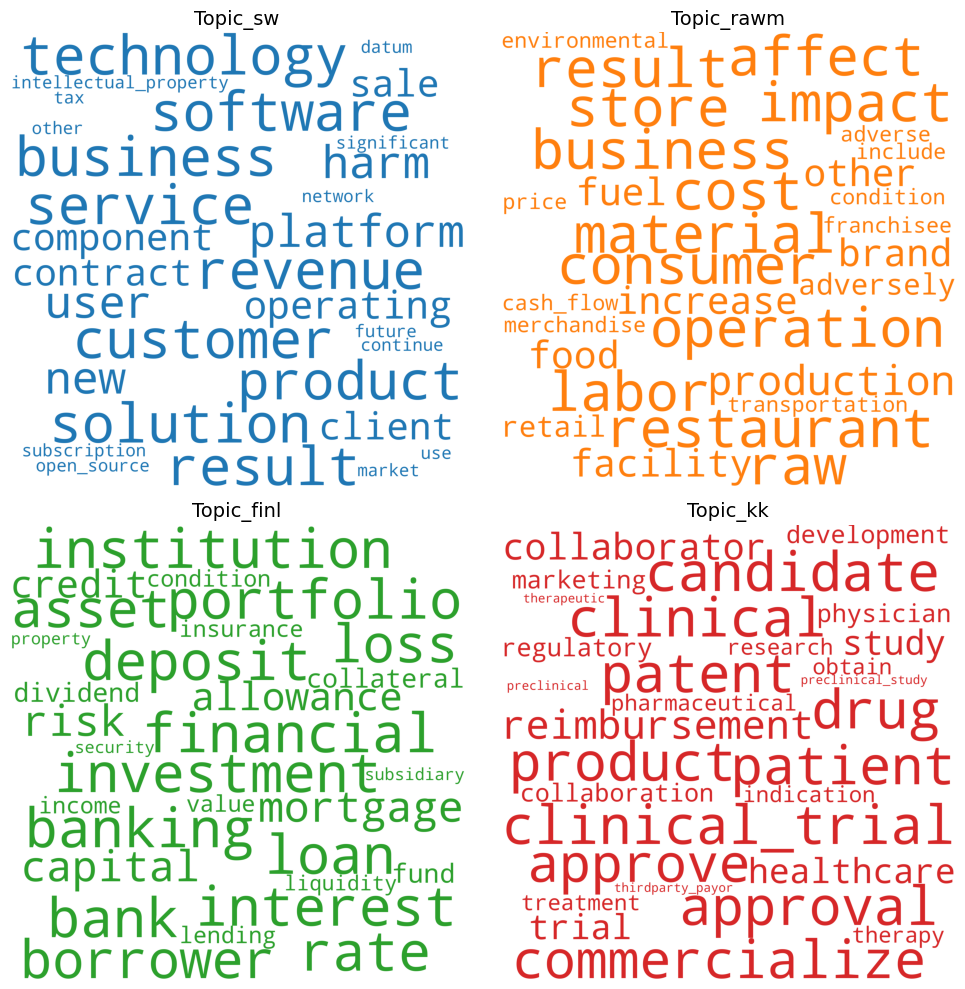

In [53]:
lambd = 0.3 # a specific relevance metric value
all_topics = {}
num_topics = lda_model.num_topics 
num_terms = 30 

for i in range(1,num_topics+1): 
    topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
all_topics_df = pd.DataFrame(all_topics)
all_topics_df.columns = ['Topic_sw', 'Topic_rawm', 'Topic_finl', 'Topic_kk']

topics = []
for i in range(len(all_topics_df.columns)):
    topics.append((i, [(word, 1) for word in all_topics_df.iloc[:, i]]))
topics

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2500,
                  max_words=40,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#topics = lda_model.show_topics(num_words = 40, formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(all_topics_df.columns[i], fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
folder_path = f"/Users/pedrovallocci/Documents/PhD (local)/Research/Github/KnowledgeKRisk_10Ks/text/{modelname}/"
plt.savefig(folder_path + 'wordclouds.png')
plt.show()